<h1> 0. Library </h1>

<h1> 1. Data Explore</h1>

In [1]:
import os
import numpy as np
from glob import glob
import cv2
import random
from sklearn.model_selection import train_test_split
from keras.models import Model
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

2024-05-23 13:23:24.097435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 13:23:24.097533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 13:23:24.235934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
LABELS = ['benign', 'malignant', 'normal']
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

In [3]:
def load_data(base_path):
    X, Y = [], []
    mask_dict = {}

    # 모든 라벨 폴더 순회
    for label in LABELS:
        img_dir = os.path.join(base_path, label)
        img_files = glob(os.path.join(img_dir, "*.png"))

        # 파일 분류 및 매핑
        for img_path in img_files:
            base_name = os.path.basename(img_path).split('_mask')[0]
            if "_mask" in img_path:
                if base_name in mask_dict:
                    mask_dict[base_name].append(img_path)
                else:
                    mask_dict[base_name] = [img_path]
            else:
                X.append(img_path)
                if base_name not in mask_dict:
                    mask_dict[base_name] = []

    # 마스크 리스트 Y 구성
    for x in X:
        base_name = os.path.splitext(os.path.basename(x))[0]
        if base_name in mask_dict and mask_dict[base_name]:
            Y.append(mask_dict[base_name])
        else:
            print(f"No matching masks found for image {x}")

    return X, Y


In [4]:
def combine_masks(mask_paths, height, width):
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (width, height))
        combined_mask = np.maximum(combined_mask, mask)
    return combined_mask

In [5]:
def process_images(image_paths, mask_paths_lists, height, width, IMG_CHANNELS=1):
    X = np.zeros((len(image_paths), height, width, IMG_CHANNELS), dtype=np.uint8)
    Y = np.zeros((len(image_paths), height, width, IMG_CHANNELS), dtype=np.uint8)

    for i, (image_path, mask_paths) in enumerate(zip(image_paths, mask_paths_lists)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (width, height))
        image = np.expand_dims(image, axis=-1)
        X[i] = image

        combined_mask = combine_masks(mask_paths, height, width)
        combined_mask = np.expand_dims(combined_mask, axis=-1)
        Y[i] = (combined_mask / 255 >= 0.5).astype(int)
    
    return X, Y

In [6]:
X_paths, Y_paths_lists = load_data(BASE_PATH)
# 데이터 셔플링
random.seed(117)
img_mask_tuples = list(zip(X_paths, Y_paths_lists))
random.shuffle(img_mask_tuples)

# 데이터 분할: 90% 훈련, 10% 테스트
train_tuples, test_tuples = train_test_split(img_mask_tuples, test_size=0.1)

print("Training tuples: ", len(train_tuples))
print("Testing tuples: ", len(test_tuples))

Training tuples:  702
Testing tuples:  78


In [7]:
X_train, Y_train = process_images([x[0] for x in train_tuples], [x[1] for x in train_tuples], IMG_HEIGHT, IMG_WIDTH)
X_test, Y_test = process_images([x[0] for x in test_tuples], [x[1] for x in test_tuples], IMG_HEIGHT, IMG_WIDTH)

In [8]:
X_train.shape

(702, 512, 512, 1)

In [9]:
Y_train.shape

(702, 512, 512, 1)

In [10]:
# 입력 레이어
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = layers.Lambda(lambda x: x / 255)(inputs)

# 인코더 블록 1
c1 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = layers.BatchNormalization()(c1)
c1 = layers.Dropout(0.1)(c1)
c1 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
c1 = layers.BatchNormalization()(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

# 인코더 블록 2
c2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.BatchNormalization()(c2)
c2 = layers.Dropout(0.1)(c2)
c2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
c2 = layers.BatchNormalization()(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

# 인코더 블록 3
c3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.BatchNormalization()(c3)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
c3 = layers.BatchNormalization()(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

# 인코더 블록 4
c4 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.BatchNormalization()(c4)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
c4 = layers.BatchNormalization()(c4)
p4 = layers.MaxPooling2D((2, 2))(c4)

# 인코더 블록 5
c5 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = layers.BatchNormalization()(c5)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)
c5 = layers.BatchNormalization()(c5)
p5 = layers.MaxPooling2D((2, 2))(c5)

# Bottleneck 부분
bottle = layers.Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p5)
bottle = layers.Dropout(0.3)(bottle)
bottle = layers.Conv2D(1024, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(bottle)

# 디코더 블록 1
u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottle)
u6 = layers.concatenate([u6, c5])
c6 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = layers.BatchNormalization()(c6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)
c6 = layers.BatchNormalization()(c6)

# 디코더 블록 2
u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c4])
c7 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = layers.BatchNormalization()(c7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)
c7 = layers.BatchNormalization()(c7)

# 디코더 블록 3
u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c3])
c8 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = layers.BatchNormalization()(c8)
c8 = layers.Dropout(0.1)(c8)
c8 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)
c8 = layers.BatchNormalization()(c8)

# 디코더 블록 4
u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c2])
c9 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = layers.BatchNormalization()(c9)
c9 = layers.Dropout(0.1)(c9)
c9 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)
c9 = layers.BatchNormalization()(c9)

# 디코더 블록 4
u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = layers.concatenate([u10, c1])
c10 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u10)
c10 = layers.BatchNormalization()(c10)
c10 = layers.Dropout(0.1)(c10)
c10 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c10)
c10 = layers.BatchNormalization()(c10)
# 모델 구성
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c10)
model = models.Model(inputs=[inputs], outputs=[outputs])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 31,182,881 (118.95 MB)

 Trainable params: 31,174,817 (118.92 MB)

 Non-trainable params: 8,064 (31.50 KB)

In [11]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100)

Training data shape: (702, 512, 512, 1)
Training labels shape: (702, 512, 512, 1)
Epoch 1/100


2024-05-23 13:24:20.390394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.18078, expected 1.40841
2024-05-23 13:24:20.390455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.73154, expected 1.95917
2024-05-23 13:24:20.390464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.7673, expected 1.99494
2024-05-23 13:24:20.390472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.02208, expected 2.24972
2024-05-23 13:24:20.390480: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.76641, expected 1.99404
2024-05-23 13:24:20.390488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.75537, expected 1.98301
2024-05-23 13:24:20.390496: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.44965, expected 2.67728
2024-05-23 13:24:20.390503: E external/local_xla/xla/ser

78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6540 - loss: 0.6793

2024-05-23 13:26:32.542157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 0.560924, expected 0.397026
2024-05-23 13:26:32.542216: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 137: 0.600411, expected 0.436513
2024-05-23 13:26:32.542227: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 209: 0.56535, expected 0.401452
2024-05-23 13:26:32.542235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 432: 0.635279, expected 0.471381
2024-05-23 13:26:32.542246: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 974: 0.600399, expected 0.4365
2024-05-23 13:26:32.542273: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5580: 0.617488, expected 0.45359
2024-05-23 13:26:32.542284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6240: 0.509796, expected 0.345898
2024-05-23 13:26:32.542298: E 

79/79 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6570 - loss: 0.6773 - val_accuracy: 0.0591 - val_loss: 27123.4590
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9185 - loss: 0.4482 - val_accuracy: 0.0634 - val_loss: 1276.5751
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9302 - loss: 0.3518 - val_accuracy: 0.1677 - val_loss: 62.9736
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9322 - loss: 0.2787 - val_accuracy: 0.3363 - val_loss: 22.8674
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9387 - loss: 0.2286 - val_accuracy: 0.9414 - val_loss: 0.2217
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9405 - loss: 0.2013 - val_accuracy: 0.8593 - val_loss: 0.3276
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9399 - loss: 0.2014 - val_accuracy: 0.9564 - val_loss: 0.1497
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 450ms/step - accuracy: 0.9335 - loss: 0.2232 - val_a

In [12]:
# Make a prediction
test_preds = model.predict(X_test)

# Threshold the predictions
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

2024-05-23 14:26:57.843291: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,32,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,512,512]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-05-23 14:26:58.715968: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.08131, expected 0.794404
2024-05-23 14:26:58.716027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.84152, expected 1.55461
2024-05-23 14:26:58.716037: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.66002, expected 1.37312
2024-05-23 14:26:58.716045: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] 

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step

2024-05-23 14:28:21.322027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.74954, expected 0.89217
2024-05-23 14:28:21.322080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.35584, expected 1.49847
2024-05-23 14:28:21.322089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.44592, expected 1.58854
2024-05-23 14:28:21.322097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.01492, expected 1.15754
2024-05-23 14:28:21.322105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.36575, expected 1.50837
2024-05-23 14:28:21.322112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.51018, expected 1.65281
2024-05-23 14:28:21.322120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.32345, expected 1.46607
2024-05-23 14:28:21.322128: E external/local_xla/xla/se

3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 18s/step


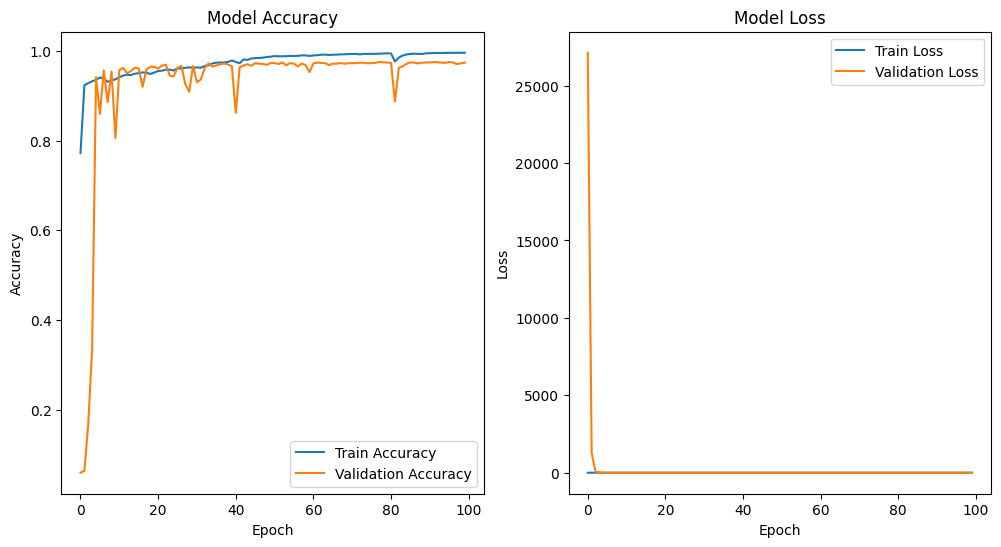

In [13]:
# Accuracy 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

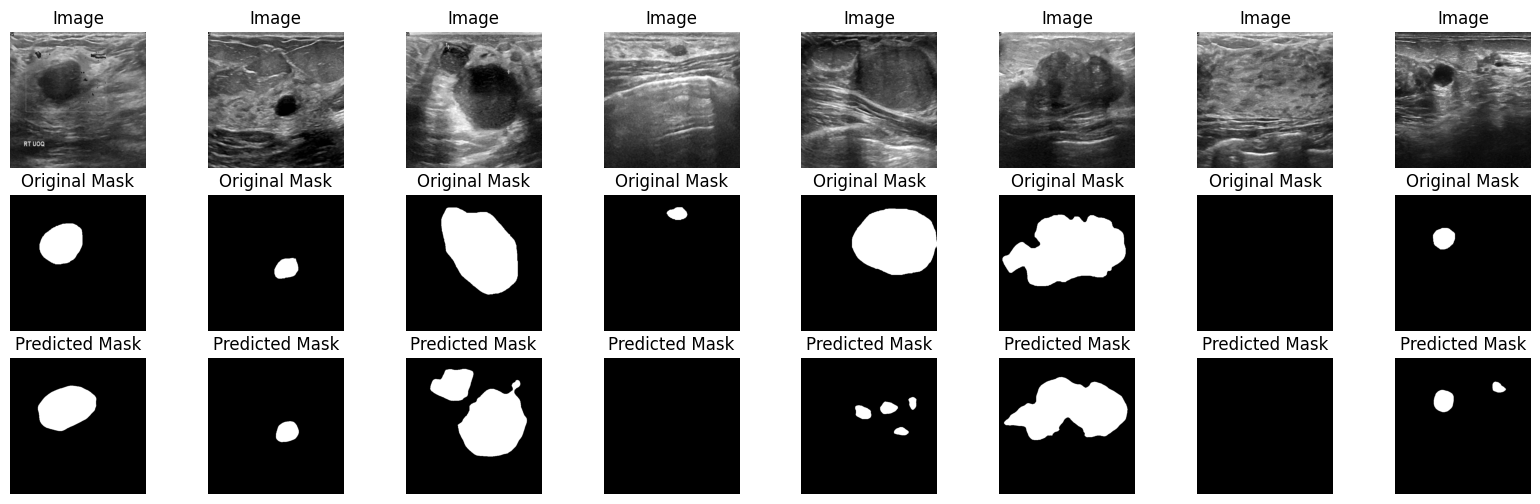

In [14]:
def plot_predictions(preds):
    plt.figure(figsize=(20, 6))

    for i in range(8):
        idx = np.random.randint(len(preds))
        plt.subplot(3, 8, i + 1)
        plt.imshow(X_test[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(3, 8, i + 9)
        plt.imshow(Y_test[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(3, 8, i + 17)
        plt.imshow(preds[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")

    plt.show()
    
plot_predictions(preds_test_thresh)

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([9.40368045e-06, 1.00008465e-01, 2.00007528e-01, 3.00006568e-01,
        4.00005639e-01, 5.00004709e-01, 6.00003779e-01, 7.00002849e-01,
        8.00001860e-01, 9.00000930e-01, 1.00000000e+00]),
 <a list of 512 BarContainer objects>)

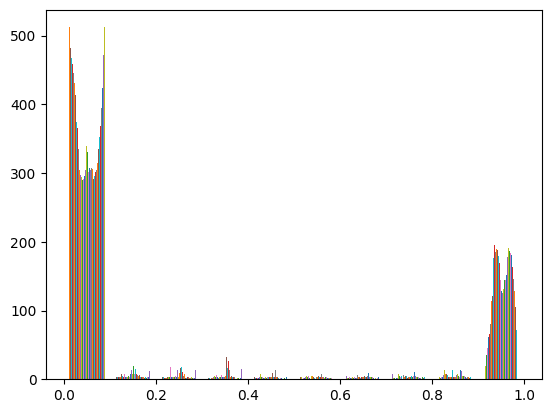

In [15]:
plt.hist(test_preds[0, :, :,0])

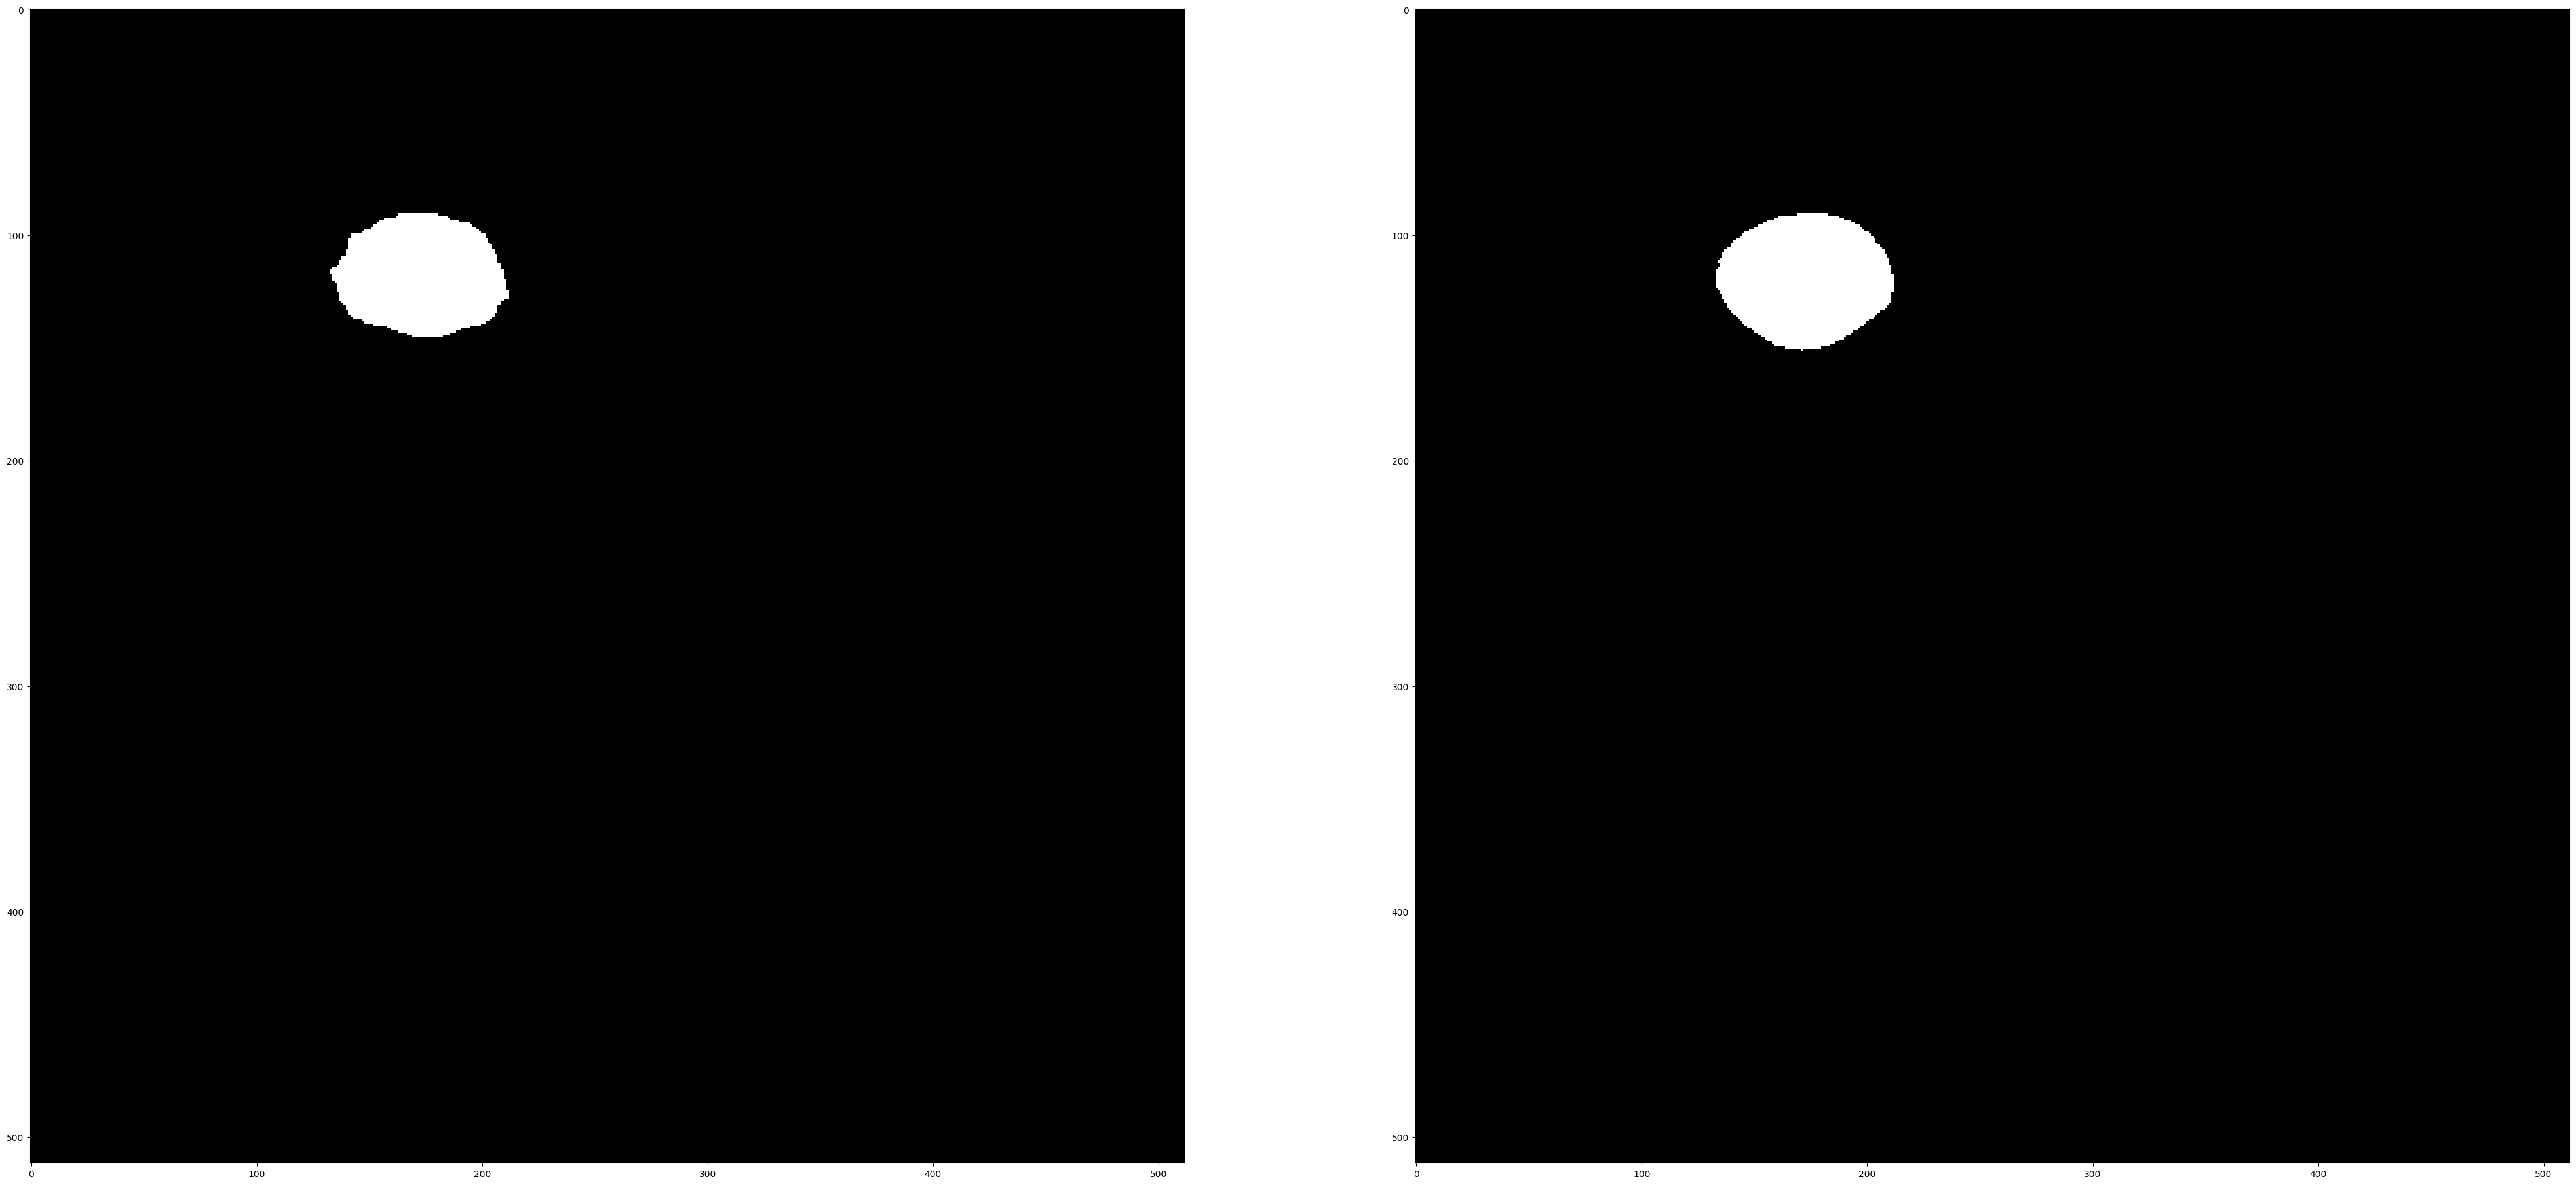

In [16]:
plt.figure(figsize=(50,50))
i=2
plt.subplot(1,2,1)
mask_image = Y_test[i, :, :,0]*255
plt.imshow(mask_image, cmap='gray')
plt.subplot(1,2,2)
test_mask = preds_test_thresh[i, :, :,0]*255
plt.imshow(test_mask, cmap='gray')

In [17]:
model.save('/kaggle/working/2024_05_23_HW3.h5')  # HDF5 파일로 저장
print("Model saved successfully!")

Model saved successfully!


In [18]:
# Dice Score
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-10) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-10)

# 모델 평가
dice_scores = []

for i in range(len(preds_test_thresh)):
    dice_score = dice_coefficient(Y_test[i], preds_test_thresh[i])
    dice_scores.append(dice_score)

average_dice_score = np.mean(dice_scores)
print("Average Dice Score:", average_dice_score)


Average Dice Score: 0.6701003492009768
